In [57]:
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, chi2
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import nltk
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset From JSON

In [58]:
# the function loads dataset from JSON and returns data to be trained on and the label - review rating in our case 
def load_dataset(ds_file):
  reviews = [] 
  y = [] 
  with open(ds_file) as f: 
    for review in f: 
        reviewDict = json.loads(review)
        reviews.append(reviewDict.get("reviewText","") + reviewDict.get("summary",""))       
        y.append(int(reviewDict["overall"])-1)
  return np.array(reviews), np.array(y)
       



## Get F1 score and Test Metrics 

In [59]:
def display_confusionMatrix(confusion_mat):
  labels = ["1 star", "2 stars", "3 stars", "4 starts", "5 stars"]
  plt.figure(figsize=(12,12))
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels)
  fig, ax = plt.subplots(figsize=(10,10))
  disp.text_= "Reviews Rating Classification"
  disp.plot(ax=ax)



In [60]:
def get_metrics(target,predicted, displayConfusionMatrix = False):
   # filling in the dictionary below with actual scores obtained on the test data
   test_results = {'class_1_F1': 0.0,
                    'class_2_F1': 0.0,
                    'class_3_F1': 0.0,
                    'class_4_F1': 0.0,
                    'class_5_F1': 0.0,
                    'accuracy': 0.0}
   test_results["accuracy"] = np.mean(predicted == target)       
   f1_scores = f1_score(target,predicted, average=None)
   for i in range(1,f1_scores.shape[0]+1):
      key = f'class_{i}_F1' 
      test_results[key] = f1_scores[i-1]
   if displayConfusionMatrix: 
    cm = confusion_matrix(target, predicted)
    display_confusionMatrix(cm)

   return test_results 



###Optional List of Stop Words

In [61]:
stop_words = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now']


starting feature extraction and classification, train data: Pet_Supplies.train.json and test: Pet_Supplies.test.json
class_1_F1 0.642051282051282
class_2_F1 0.3379844961240311
class_3_F1 0.40166204986149584
class_4_F1 0.42686567164179107
class_5_F1 0.6477732793522268
accuracy 0.515


<Figure size 864x864 with 0 Axes>

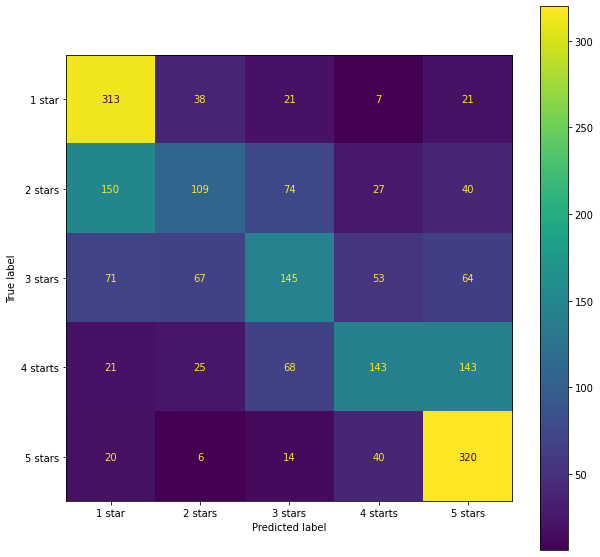

In [62]:
def classify(train_file, test_file):
    print(f'starting feature extraction and classification, train data: {train_file} and test: {test_file}')
    review_texts = []
    y = []    

    train_data , target = load_dataset(train_file)
   
        
    K = 2000 # Size of count vector (leave only the most frequent terms)
    # optional parameters for CountVectorizer include stop_words - remove stop words from corpus, max_features - limit Vocabulary to K most freq n-grams/words
    model = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),max_features=K)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=8, tol=None)),])
    model.fit(train_data, target)


    # loading test dataset..
    test_data ,test_target = load_dataset(test_file)  
    predicted = model.predict(test_data)    
    test_results = get_metrics(test_target, predicted, True)                  

    return test_results


if __name__ == '__main__':
    with open('config.json', 'r') as json_file:
        config = json.load(json_file)

    results = classify(config['train_data'], config['test_data'])

    for k, v in results.items():
        print(k, v)


##5. Extraction of K-Best Features

In [63]:
from sklearn.feature_selection import SelectKBest, chi2
def print_k_best_features(dataset_file):
  train_data , target = load_dataset(dataset_file)  
  count_vect = CountVectorizer(ngram_range=(1,3), stop_words=stop_words)
  counts=count_vect.fit_transform(train_data)
  select = SelectKBest(score_func=chi2, k=30)
  select.fit_transform(counts,target)
  k_best=np.asarray(count_vect.get_feature_names_out())[select.get_support()]
  print(k_best)
print_k_best_features('Automotive.test.json')  


['10' 'charger' 'easy' 'even' 'five' 'five stars' 'four' 'four stars'
 'garbage' 'great' 'junk' 'light circuit' 'metal polish' 'money' 'ok'
 'one' 'one star' 'return' 'service' 'star' 'stars' 'three' 'three stars'
 'two' 'two stars' 'waste' 'waste money' 'works' 'works great' 'wrong']


## 6.Cross Domain Classification

starting feature extraction and classification, train data: Pet_Supplies.train.json and test: Automotive.test.json
class_1_F1 0.642051282051282
class_2_F1 0.3379844961240311
class_3_F1 0.40166204986149584
class_4_F1 0.42686567164179107
class_5_F1 0.6477732793522268
accuracy 0.515


<Figure size 864x864 with 0 Axes>

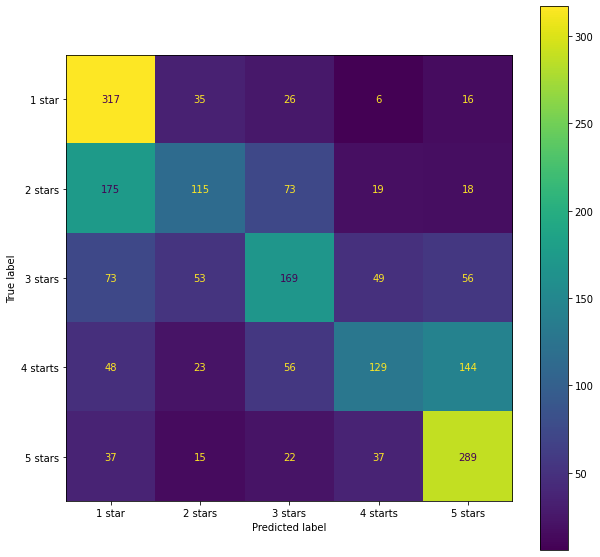

In [64]:
# now we are going to predict on the Automotive reviews using a model trained on pets reviews 
test_file = "Automotive.test.json"
test_results = classify(config['train_data'], test_file)

for k, v in results.items():
  print(k, v)




## Creating a model trained on the other datasets

starting feature extraction and classification, train data: Automotive.train.json and test: Automotive.test.json
class_1_F1 0.6054687500000001
class_2_F1 0.32125984251968503
class_3_F1 0.4410112359550562
class_4_F1 0.40916030534351144
class_5_F1 0.6283367556468172
accuracy 0.5045


<Figure size 864x864 with 0 Axes>

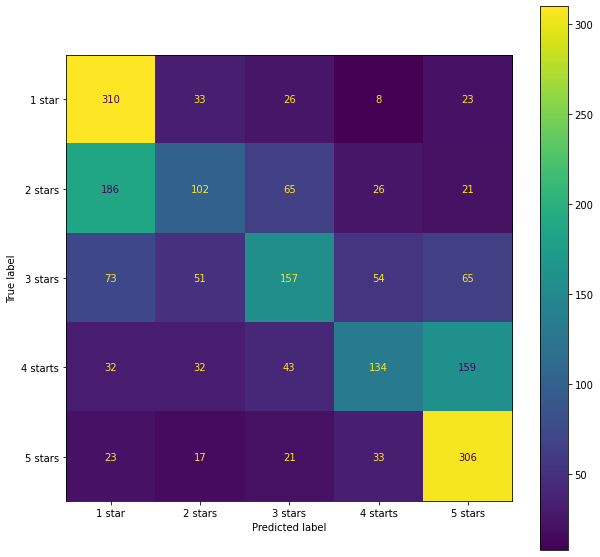

In [65]:
config = {"train_data" : "Automotive.train.json",
          "test_data" : "Automotive.test.json"}
results = classify(config['train_data'], config['test_data'])
for k, v in results.items():
  print(k, v)          


starting feature extraction and classification, train data: Sports_and_Outdoors.train.json and test: Sports_and_Outdoors.test.json
class_1_F1 0.6392600205549847
class_2_F1 0.385692068429238
class_3_F1 0.4463276836158192
class_4_F1 0.4464555052790347
class_5_F1 0.6732477788746298
accuracy 0.541


<Figure size 864x864 with 0 Axes>

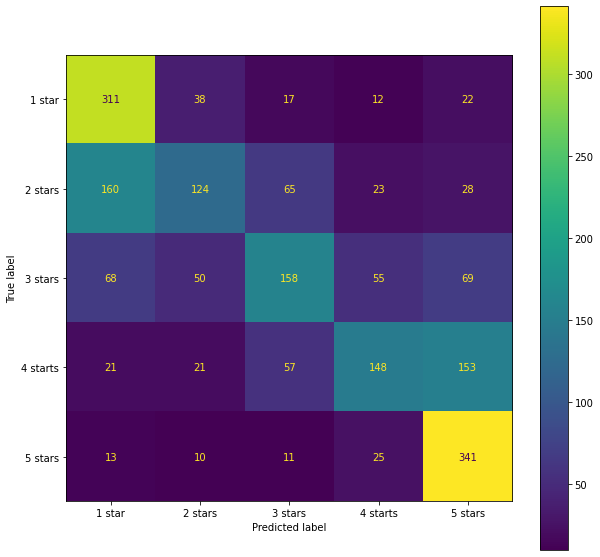

In [66]:
config = {"train_data" : "Sports_and_Outdoors.train.json",
          "test_data" : "Sports_and_Outdoors.test.json"}
results = classify(config['train_data'], config['test_data'])

for k, v in results.items():
  print(k, v)          
